In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score , mean_absolute_error, mean_squared_error , mean_absolute_percentage_error, median_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 


In [2]:
print (f"Numpy version:{np.__version__}")
print (f"Pandas version:{pd.__version__}")


Numpy version:1.23.2
Pandas version:1.4.3


In [3]:
def get_data_separated(dataframe, test_size=0.2, random_state=None):
    target_feature = ['ΔVC -p'] #+ ΔVC-m,ΔVC -p
    features_to_drop = ['substituent','molecular_formula','Name','canonical_smiles','ΔVC-m','cid']

    # Assuming 'target_feature' is the dependent variable (y)
    y = dataframe[target_feature]
    X = dataframe.drop(columns=features_to_drop + target_feature)
    X =X.fillna(0)
    features = X.columns.to_list()

    # Split into training and testing sets, excluding data_val
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    # create the next sets , you split the temp data into halfs 
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test ,features


In [4]:
def scaling_data(X_train,X_val,X_test):

    scaler = StandardScaler()

    scaler.fit(X_train)
    
    # filename = '../models/scaler_for_all_features.sav'
    # pickle.dump(scaler, open(filename, 'wb'))
    
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_val = scaler.transform(X_val)
    return scaled_train,scaled_val,scaled_test

In [5]:
def save_metrics_results(model,X_test,y_test,tag):

    y_pred = model.predict(X_test)
    r2 = r2_score(y_pred=y_pred,y_true=y_test)
    MAE = mean_absolute_error(y_pred=y_pred,y_true=y_test) 
    MSE = mean_squared_error(y_pred=y_pred,y_true=y_test) 
    MAPE = mean_absolute_percentage_error(y_pred=y_pred,y_true=y_test)
    MedAE = median_absolute_error(y_pred=y_pred,y_true=y_test)
    # MSLE = mean_squared_log_error(y_pred=y_pred,y_true=y_test)

    results = {
        "R^2": r2,
        "MAE":MAE,
        "MSE":MSE,
        "MAPE":MAPE ,
        "MedAE":MedAE,
        # "MSLE":MSLE
    }
    mean_df = pd.DataFrame(data=results,index=[f"{tag}"])
    return mean_df

In [6]:
rng = np.random.RandomState(42)
# data loading 
path = '/Users/barradd/Documents/GitHub/machine_learning_chem_RGS/data/pubchem_data_2023-12-05_343_samples.csv'
df_all_data = pd.read_csv(path)


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test ,features = get_data_separated(df_all_data,random_state=rng)
X_train, X_val, X_test = scaling_data(X_train, X_val, X_test)

In [8]:
base_RFR = RandomForestRegressor()
base_GBR = GradientBoostingRegressor()

In [9]:
base_RFR.fit(X_train, y_train.to_numpy().ravel())
base_GBR.fit(X_train, y_train.to_numpy().ravel())

GradientBoostingRegressor()

In [10]:
metrics_df_val_RFR = save_metrics_results(model=base_RFR, X_test=X_val,y_test=y_val,tag="RFR_val")
metrics_df_test_RFR = save_metrics_results(model=base_RFR, X_test=X_test,y_test=y_test,tag="RFR_test")
metrics_df_val_GBR = save_metrics_results(model=base_GBR, X_test=X_val,y_test=y_val,tag="GBR_val")
metrics_df_test_GBR = save_metrics_results(model=base_GBR, X_test=X_test,y_test=y_test,tag="GBR_test")

In [11]:
pd.concat([metrics_df_val_RFR,metrics_df_test_RFR,metrics_df_val_GBR,metrics_df_test_GBR])

,R^2,MAE,MSE,MAPE,MedAE
RFR_val,0.893497,1.604704,8.352815,0.345705,0.462168
RFR_test,0.927406,1.509263,5.771497,0.324909,0.715719
GBR_val,0.889882,1.736785,8.636329,0.447291,0.808533
GBR_test,0.929320,1.535572,5.619311,0.446621,0.972473


In [12]:
def plot_the_r2(y_true, X_pred , model): #(model,X_test,y_test,tag)
    y_true = y_true.to_numpy().ravel()
    y_pred = model.predict(X_pred)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red')
    plt.title('Real Values vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot Residuals
    residuals = y_true - y_pred

    plt.subplot(1, 2, 2)
    plt.scatter(y_true, residuals, color='green')
    plt.axhline(y=0, linestyle='--', color='red')
    plt.title('Residual Plot')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

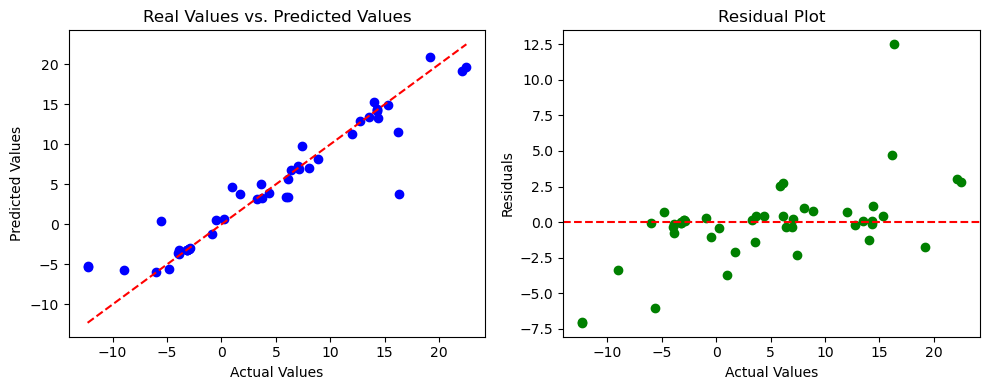

In [13]:
plot_the_r2(y_true=y_val, X_pred = X_val , model = base_RFR )

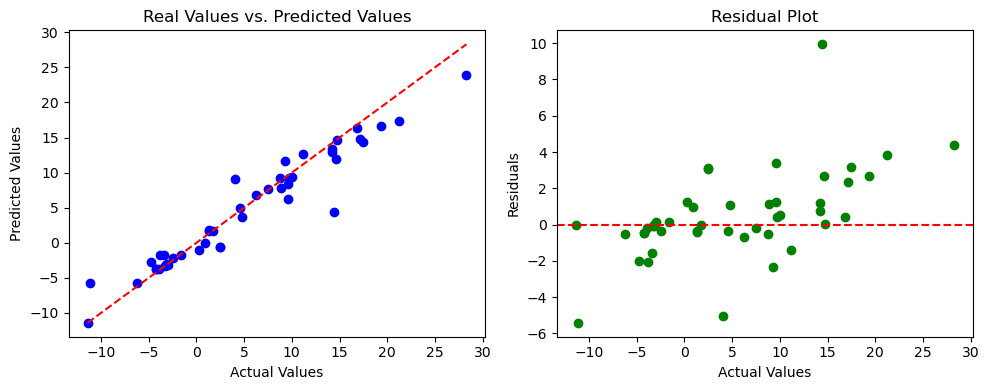

In [14]:
plot_the_r2(y_true=y_test, X_pred = X_test , model = base_RFR )

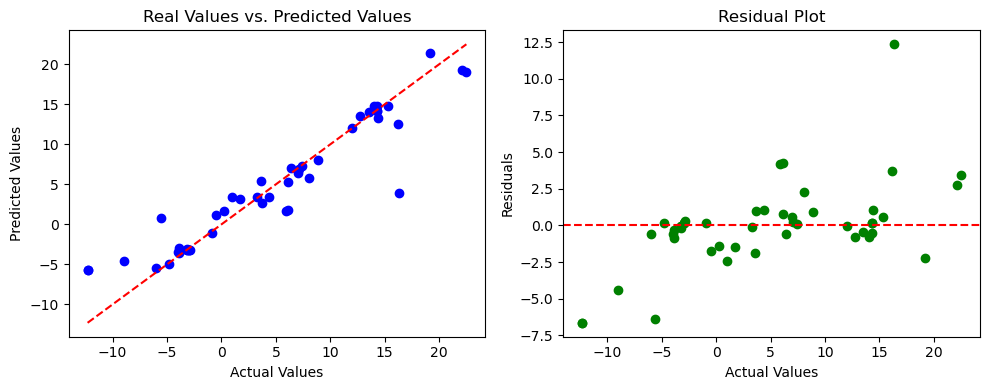

In [15]:
plot_the_r2(y_true=y_val, X_pred = X_val , model = base_GBR )

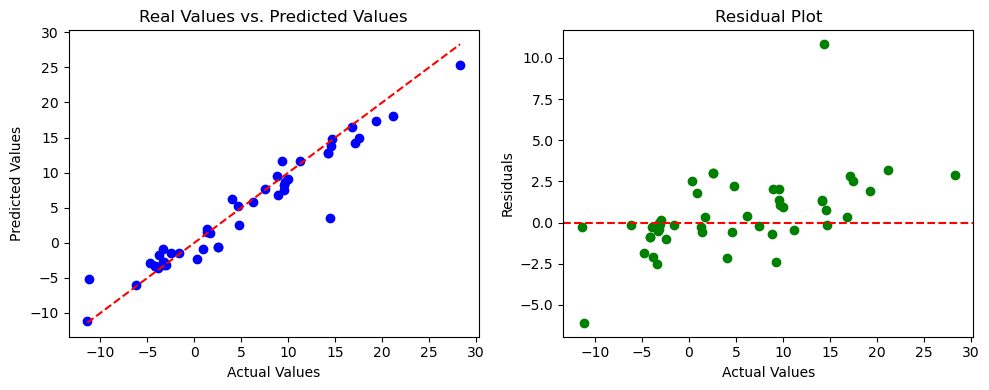

In [16]:
plot_the_r2(y_true=y_test, X_pred = X_test , model = base_GBR )

In [23]:
def plot_feature_importance(model, feature_names):
    """
    Plot feature importances from a trained RandomForestRegressor.

    Parameters:
    - model: Trained RandomForestRegressor model
    - feature_names: List of feature names used in the model
    """
    if not isinstance(model, RandomForestRegressor):
        raise ValueError("The provided model is not a RandomForestRegressor.")

    importances = model.feature_importances_
    indices = range(len(importances))

    # Sort features based on importance
    sorted_indices = sorted(indices, key=lambda i: importances[i], reverse=True)
    sorted_importances = [importances[i] for i in sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Plotting
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(sorted_importances)), sorted_importances, align="center")
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Random Forest Regressor - Feature Importance")
    plt.show()

# Example usage:
# Assuming you have a trained RandomForestRegressor 'rf_model' and a list of feature names 'feature_names'
# plot_feature_importance(rf_model, feature_names)


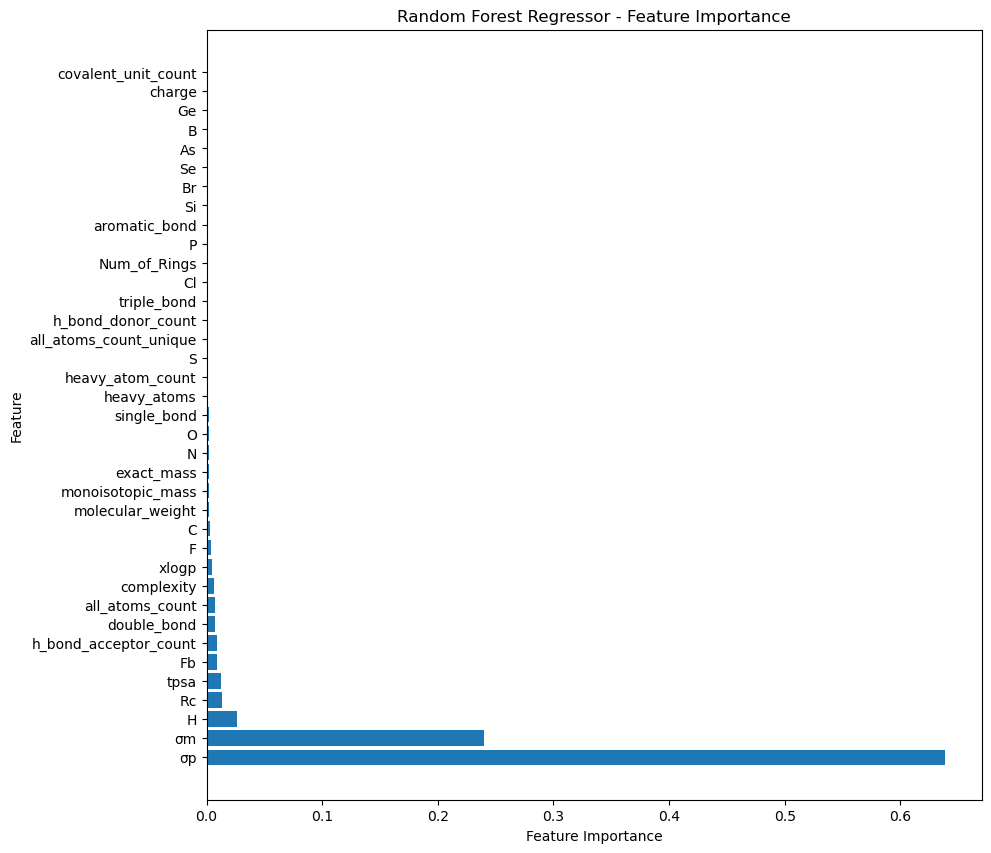

In [24]:
plot_feature_importance(model= base_RFR , feature_names=features)